<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [57]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [58]:
!nvidia-smi

Sat Sep  5 21:27:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |    667MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
%pip install cupy-cuda101

In [60]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data,metric_cnr, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [61]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [62]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [63]:
X = X.drop(['ID','WF','Set'],axis=1)

In [64]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,-2.248500,-3.257800,1.254603,-0.289687,286.440,82.543144,3.958410,0.966685,1.287613,359.773077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-11,-223,-168,-233,-251,-223,-184,-190,-251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.440,82.543144,-2.248500,-3.257800,1.254603,-0.289687
2018-05-01 02:00:00,-2.434500,-1.446100,2.490908,-0.413370,286.260,99.990844,2.831607,0.535998,2.524975,359.835547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-11,-223,-168,-233,-250,-223,-184,-190,-250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.440,99.990844,-2.248500,-1.446100,2.490908,-0.289687
2018-05-01 03:00:00,-1.220571,-0.266871,0.997093,-1.415138,286.575,98.367235,1.249405,0.215257,1.731130,359.043004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-10,-223,-168,-233,-250,-223,-184,-190,-250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.575,99.990844,-1.220571,-0.266871,2.490908,-0.289687
2018-05-01 04:00:00,3.706500,-6.217400,0.689598,-0.961441,284.780,94.860604,7.238384,358.966787,1.183180,359.051417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-10,-223,-168,-233,-250,-223,-184,-189,-250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.575,99.990844,3.706500,-0.266871,2.490908,-0.289687
2018-05-01 05:00:00,3.813400,-5.444600,0.290994,-0.294963,284.460,95.905879,6.647232,359.040198,0.414344,359.207829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-10,-222,-168,-233,-250,-223,-184,-189,-250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.575,99.990844,3.813400,-0.266871,2.

## Fill NaN's

To avoid Exploding Gradients, here the NaN's are filled.

In [65]:
X = X.fillna(method="ffill", axis=1) # ZOH
X = X.fillna(0)

In [66]:
y = y.fillna(method="ffill", axis=1) # ZOH
y = y.fillna(0)

## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [67]:
directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))

directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
directions = directions.reset_index().drop('Time',axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [68]:
X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
X_columns = X.columns

In [69]:
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=X_columns)

In [70]:
X = pd.concat([X,directions],axis=1)

In [71]:
y = y.drop('ID',axis=1)
y = scaler.fit_transform(y)
y = pd.DataFrame(y)

In [72]:
X.head()

,U_100m,V_100m,U_10m,V_10m,T,CLCT,Wind Speed 100m,Wind Speed 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,U_100mLast_Month_Variance,V_100mLast_Month_Variance,U_10mLast_Month_Variance,V_10mLast_Month_Variance,cos_day,...,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max,Sin_Wind Direction 100m,Cos_Wind Direction 100m,Sin_Wind Direction 10m,Cos_Wind Direction 10m
0,-0.138088,0.115046,0.101243,0.289424,-0.287661,0.650863,-0.698185,-0.856981,0.997117,0.997117,0.997117,0.999317,0.999317,0.999317,0.999346,0.999346,0.999346,0.999362,0.999362,0.999362,0.999335,0.999335,0.999335,0.999347,0.999347,0.999347,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-0.9589,-1.0,-1.0,-1.0,-0.680436,-1.0,1.0,...,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.016871,0.999858,-0.003961,0.999992
1,-0.149704,0.205944,0.226318,0.279576,-0.298535,0.999817,-0.785083,-0.714591,0.998583,0.998583,0.998583,0.999664,0.999664,0.999664,0.999679,0.999679,0.999679,0.999686,0.999686,0.999686,0.999673,0.999673,0.999673,0.999679,0.999679,0.999679,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-0.9589,-1.0,-1.0,-1.0,-0.680436,-1.0,1.0,...,-1.0,-0.992308,-1.0,-1.0,-1.000000,-0.992308,-0.996413,-0.996405,-0.992565,-0.992744,-0.994302,-0.994302,-0.999287,-0.999191,-0.992483,-0.992465,-0.993161,-0.993328,-0.99242,-0.992398,-0.993832,-0.993718,-0.99232,-0.992295,-0.992804,-0.992898,-0.992268,-0.992257,-0.992965,-0.992974,-1.000000,0.998951,-1.000000,-0.794570,-0.721671,-1.0,0.009355,0.999956,-0.002870,0.999996
2,-0.073889,0.265110,0.075191,0.199814,-0.279505,0.967345,-0.907100,-0.805943,0.979989,0.979989,0.979989,0.995260,0.995260,0.995260,0.995462,0.995462,0.995462,0.995573,0.995573,0.995573,0.995384,0.995384,0.995384,0.995468,0.995468,0.995468,-0.272727,-1.0,-1.0,1.0,1.0,1.0,1.0,-0.9589,-1.0,-1.0,-1.0,-0.680436,-1.0,1.0,...,-1.0,-0.992308,-1.0,-1.0,-1.000000,-0.992308,-0.996413,-0.996405,-0.992565,-0.992744,-0.994302,-0.994302,-0.999287,-0.999191,-0.992483,-0.992465,-0.993161,-0.993328,-0.99242,-0.992398,-0.993832,-0.993718,-0.99232,-0.992295,-0.992804,-0.992898,-0.992268,-0.992257,-0.992965,-0.992974,-0.987333,0.998951,-0.887181,-0.660856,-0.721671,-1.0,0.003757,0.999993,-0.016702,0.999861
3,0.233830,-0.033446,0.044082,0.235938,-0.387943,0.897212,-0.445239,-0.868999,0.980186,0.980186,0.980186,0.995307,0.995307,0.995307,0.995507,0.995507,0.9

In [73]:
y

,0
0,-0.996055
1,-0.986193
2,-0.956607
3,-0.923077
4,-0.919132
...,...
6234,-0.911243
6235,-0.893491
6236,-0.990138
6237,-0.992110


In [74]:
y.shape

(6239, 1)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [75]:
n_steps = 60

In [76]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [77]:
def shift_save(df,n_steps):
  empty = pd.DataFrame(np.zeros((n_steps-1,df.shape[1])),columns=df.columns)
  df = pd.concat([empty,df])
  return df

In [78]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [80]:
n_features = sample_X.shape[2]

## Model

Here, a function to create the Model usin Keras is defined.

In [81]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.1)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.1)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57,stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.1)(hidden_3)


  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [82]:
input_shape = (n_steps,n_features)

In [83]:
model = LSTM_Model(input_shape)

In [84]:
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(1, 60, 95)]             0         
_________________________________________________________________
lstm_21 (LSTM)               (1, 60, 128)              114688    
_________________________________________________________________
dropout_21 (Dropout)         (1, 60, 128)              0         
_________________________________________________________________
lstm_22 (LSTM)               (1, 60, 87)               75168     
_________________________________________________________________
dropout_22 (Dropout)         (1, 60, 87)               0         
_________________________________________________________________
lstm_23 (LSTM)               (1, 57)                   33060     
_________________________________________________________________
dropout_23 (Dropout)         (1, 57)                 

## Validation

In [85]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
batch_size = 1

#n_rows = round(X.shape[0]/k_fold_splits)

In [86]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    #train_index = train_index[-n_rows:]
    #test_index = test_index[-n_rows:]

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape,batch_size=batch_size)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Train and Validation Score
    train_score = np.array(history.history['root_mean_squared_error']).mean()
    val_score = np.array(history.history['val_root_mean_squared_error']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    preds = tf.cast(preds, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(y_test,preds)
    test_score = m.result().numpy()

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

Epoch 1/10
724/724 [==============================] - 8s 10ms/step - loss: 0.1520 - root_mean_squared_error: 0.3898 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1801
Epoch 2/10
724/724 [==============================] - 7s 9ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1825
Epoch 3/10
724/724 [==============================] - 7s 9ms/step - loss: 0.2120 - root_mean_squared_error: 0.4604 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1897
Epoch 4/10
724/724 [==============================] - 7s 9ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1785
Epoch 1/10
1503/1503 [==============================] - 16s 11ms/step - loss: 0.1569 - root_mean_squared_error: 0.3961 - val_loss: 0.1081 - val_root_mean_squared_error: 0.3288
Epoch 2/10
1503/1503 [==============================] - 14s 10ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869 - val_loss: 0.14

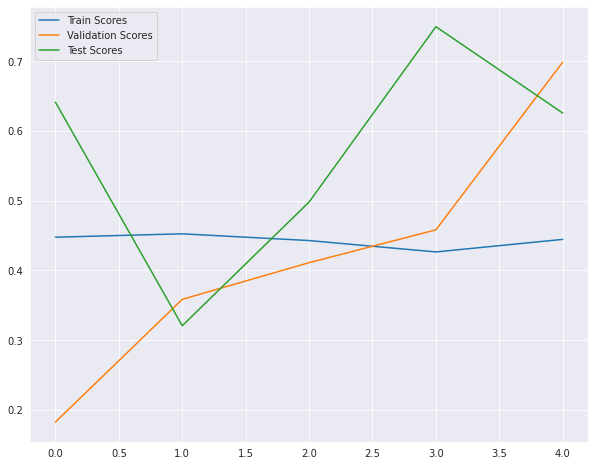

In [87]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_scores)),train_scores,label='Train Scores')
plt.plot(range(len(val_scores)),val_scores,label='Validation Scores')
plt.plot(range(len(test_scores)),test_scores,label='Test Scores')
plt.legend()

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [88]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)

In [89]:
#X_train, y_train = X_train.iloc[-n_rows:],y_train.iloc[-n_rows:]

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [91]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [92]:
model = LSTM_Model(input_shape)

In [93]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4619/4619 [==============================] - 48s 10ms/step - loss: 0.1339 - root_mean_squared_error: 0.3660 - val_loss: 0.1287 - val_root_mean_squared_error: 0.3588
Epoch 2/10
4619/4619 [==============================] - 47s 10ms/step - loss: 0.0875 - root_mean_squared_error: 0.2958 - val_loss: 0.2155 - val_root_mean_squared_error: 0.4642
Epoch 3/10
4619/4619 [==============================] - 47s 10ms/step - loss: 0.0777 - root_mean_squared_error: 0.2787 - val_loss: 0.2341 - val_root_mean_squared_error: 0.4838
Epoch 4/10
4619/4619 [==============================] - 47s 10ms/step - loss: 0.0692 - root_mean_squared_error: 0.2631 - val_loss: 0.1402 - val_root_mean_squared_error: 0.3745
Epoch 5/10
4619/4619 [==============================] - 45s 10ms/step - loss: 0.0628 - root_mean_squared_error: 0.2507 - val_loss: 0.1287 - val_root_mean_squared_error: 0.3588
Epoch 6/10
4619/4619 [==============================] - 46s 10ms/step - loss: 0.0552 - root_mean_squared_error: 0.2349 -

In [94]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [95]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [96]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [97]:
metric_cnr(preds,y_holdout)

('CAPE', 50.149859894553565)

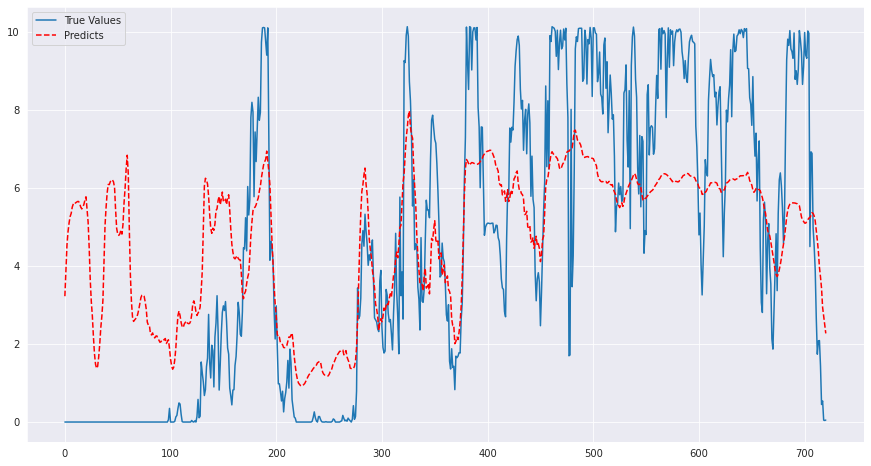

In [98]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

In [105]:
def preprocessing_X(X):

  scaler = MinMaxScaler(feature_range=(-1,1))

  X_saved_columns = X[['ID','WF','Set','Month_Number']]
  X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
  X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

  # Fill NaN's
  X = X.fillna(method="ffill", axis=1) # ZOH
  X = X.fillna(0)

  # Scaling Data
  directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
  directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
  directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
  directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
  directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
  directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  directions = directions.reset_index().drop('Time',axis=1)

  X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  X_columns = X.columns

  X = scaler.fit_transform(X)
  X = pd.DataFrame(X,columns=X_columns)
  X = pd.concat([X,directions],axis=1)
  X = pd.concat([X,X_saved_columns],axis=1)

  return X

In [100]:
def preprocessing_y(y):

  scaler = MinMaxScaler(feature_range=(-1,1))

  y = y.fillna(method="ffill", axis=1) # ZOH
  y = y.fillna(0)
  y = y.drop('ID',axis=1)
  y = scaler.fit_transform(y)
  y = pd.DataFrame(y)

  return y,scaler

In [114]:
def WF_submit_gen(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test = full_X_test.reset_index().drop('index',axis=1)
  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue
    
    # Separate Month Data on Numpy Matrix
    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [115]:
final_preds = pd.DataFrame()
for WF in full_data['WF'].unique():
  WF_preds = WF_submit_gen(full_data,full_label,WF,input_shape,batch_size)
  final_preds = final_preds.append(WF_preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Farm WF1 - Month 1
Epoch 1/10
4944/4944 [==============================] - 54s 11ms/step - loss: 0.2469 - root_mean_squared_error: 0.4969 - val_loss: 0.5231 - val_root_mean_squared_error: 0.7233
Epoch 2/10
4944/4944 [==============================] - 53s 11ms/step - loss: 0.2648 - root_mean_squared_error: 0.5145 - val_loss: 0.5266 - val_root_mean_squared_error: 0.7257
Epoch 3/10
4944/4944 [==============================] - 53s 11ms/step - loss: 0.2586 - root_mean_squared_error: 0.5086 - val_loss: 0.5929 - val_root_mean_squared_error: 0.7700
Epoch 4/10
4944/4944 [==============================] - 53s 11ms/step - loss: 0.2655 - root_mean_squared_error: 0.5153 - val_loss: 0.5556 - val_root_mean_squared_error: 0.7454
Farm WF1 - Month 2
Epoch 1/10
5250/5250 [==============================] - 57s 11ms/step - loss: 0.2577 - root_mean_squared_error: 0.5077 - val_loss: 0.4439 - val_root_mean_squared_error: 0.6663
Epoch 2/10
5250/5250 [==============================] - 56s 11ms/step - loss: 0.26

KeyboardInterrupt: ignored

In [ ]:
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

In [ ]:
final_preds

,Production
ID,
37376,2.204020
37377,2.211824
37378,2.214334
37379,2.217317
37380,2.218236
...,...
73900,1.569189
73901,1.569176
73902,1.569184


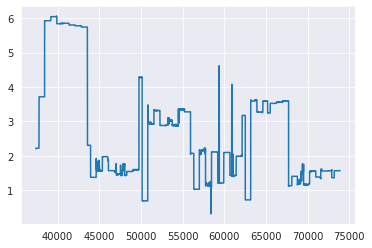

In [ ]:
plt.plot(final_preds.index,final_preds['Production'])

In [ ]:
final_preds.to_csv('Submission_LSTM.csv')

In [ ]:
from google.colab import files
files.download('Submission_LSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>